Data overview

In [ ]:
import numpy as np
import pandas as pd
import scipy
import scipy.signal
import datetime
import matplotlib
import matplotlib.pyplot as plt
import tqdm
import random
import os
import glob
from pathlib import Path


In [ ]:
#from google.colab import drive
#drive.mount('/content/gdrive')

In [ ]:
#Defines
#/drive/MyDrive/Kaggle/predict-volcanic-eruptions-ingv-oe
train_csv_path = "./drive/MyDrive/Kaggle/predict-volcanic-eruptions-ingv-oe/train.csv"
sample_csv_path = "./drive/MyDrive/Kaggle/predict-volcanic-eruptions-ingv-oe/sample_submission.csv"
single_segment = "./drive/MyDrive/Kaggle/predict-volcanic-eruptions-ingv-oe/train/1003520023.csv"
train_data_path = "./drive/MyDrive/Kaggle/predict-volcanic-eruptions-ingv-oe/train/"
test_data_path = "./drive/MyDrive/Kaggle/predict-volcanic-eruptions-ingv-oe/test/"
trainParams_path = "./drive/MyDrive/Kaggle/predict-volcanic-eruptions-ingv-oe/feature extraction/trainParams.csv"
testParams_path = "./drive/MyDrive/Kaggle/predict-volcanic-eruptions-ingv-oe/feature extraction/testParams.csv"

sample_size = 10


In [ ]:
train = pd.read_csv(train_csv_path)
sample_submission = pd.read_csv(sample_csv_path)


In [ ]:
# Convert 'time_to_eruption'to hours:minutes:seconds (Just for reference)
#train['days_hours_minutes_seconds'] = (train['time_to_eruption']
             #     .apply(lambda x:datetime.timedelta(seconds = x/100))) 100???? why


In [ ]:
train


segment_id  time_to_eruption
0     1136037770          12262005
1     1969647810          32739612
2     1895879680          14965999
3     2068207140          26469720
4      192955606          31072429
...          ...               ...
4426   873340274          15695097
4427  1297437712          35659379
4428   694853998          31206935
4429  1886987043           9598270
4430  1100632800          20128938

[4431 rows x 2 columns]

In [ ]:
train['time_to_eruption'].describe()


count    4.431000e+03
mean     2.284891e+07
std      1.348439e+07
min      6.250000e+03
25%      1.127016e+07
50%      2.246559e+07
75%      3.434356e+07
max      4.904609e+07
Name: time_to_eruption, dtype: float64

In [ ]:
print('Median:', train['time_to_eruption'].median())
print('Skew:', train['time_to_eruption'].skew()) #symetric?
print('Std:', train['time_to_eruption'].std())
print('Kurtosis:', train['time_to_eruption'].kurtosis()) #heavy-tailed?
print('Mean:', train['time_to_eruption'].mean())

Median: 22465586.0
Skew: 0.059347778798359965
Std: 13484385.863632679
Kurtosis: -1.166601027916375
Mean: 22848906.832769126


In [ ]:
sample_submission

In [ ]:
# From DF to Dic for O(1) access
train_dic = dict(zip(train.segment_id, train.time_to_eruption))
train_dic

Look on single segment


In [ ]:
segment = pd.read_csv(single_segment,dtype ="int16")
segment.describe()

sensor_1      sensor_2  ...      sensor_9     sensor_10
count  60001.000000  60001.000000  ...  60001.000000  60001.000000
mean      -2.655972      2.833653  ...     -3.991817     -6.967667
std      352.515183    505.483617  ...    330.512391    758.130409
min    -1698.000000  -6830.000000  ...  -2022.000000  -2815.000000
25%     -236.000000   -286.000000  ...   -220.000000   -502.000000
50%        0.000000      0.000000  ...      0.000000      0.000000
75%      235.000000    294.000000  ...    210.000000    492.000000
max     1407.000000   6472.000000  ...   1306.000000   4018.000000

[8 rows x 10 columns]

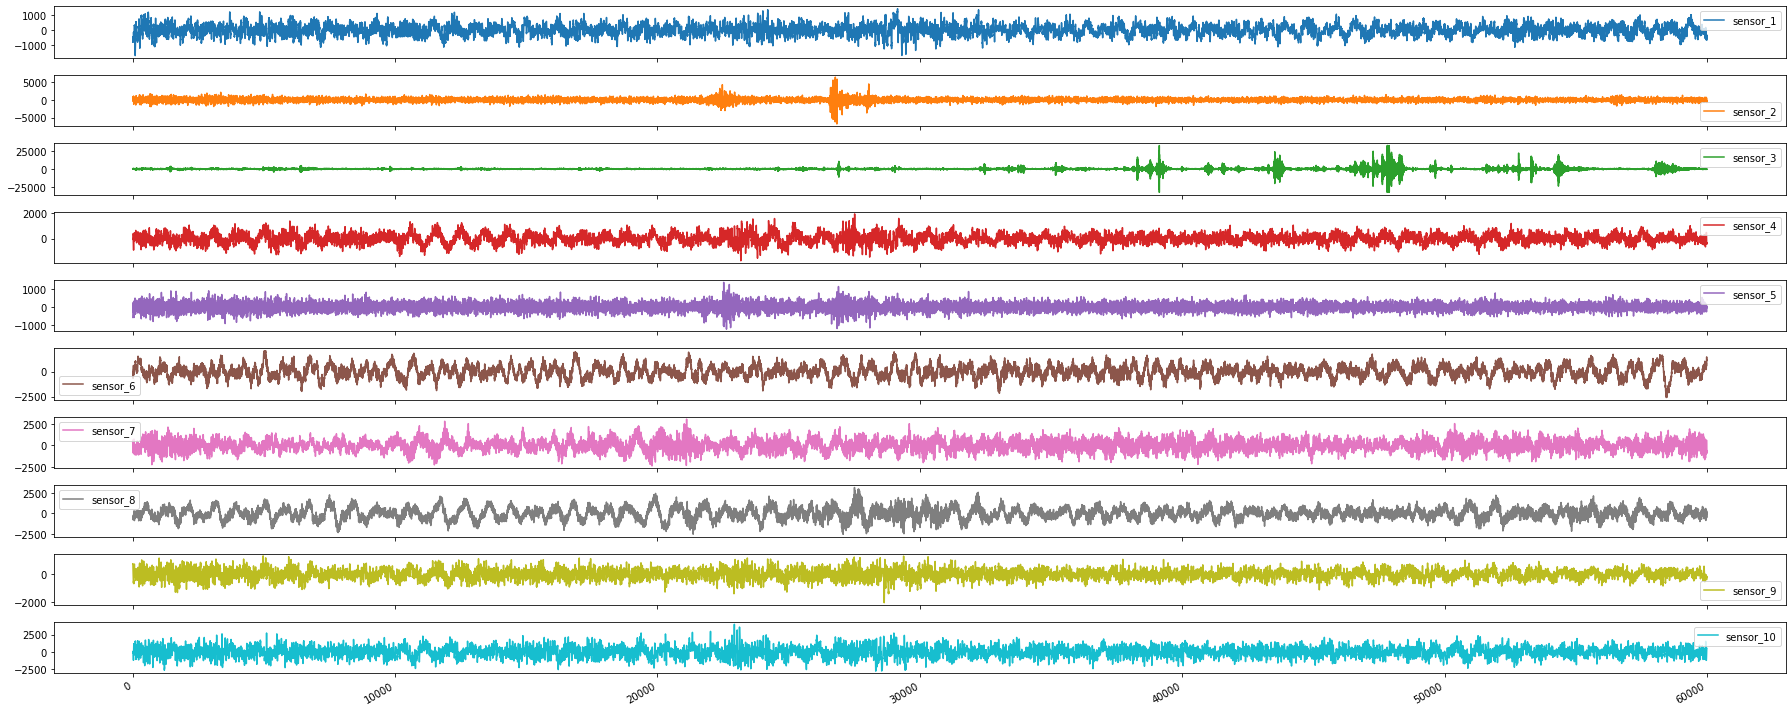

In [ ]:
segment.fillna(0).plot(subplots=True, figsize=(25, 10))
plt.tight_layout()
plt.show()

Merge data for train/test

In [ ]:
train_segmnets = glob.glob(os.path.join(train_data_path,"*.csv"))
test_segmnets = glob.glob(os.path.join(test_data_path,"*.csv"))

train_segmnets

In [ ]:
#lst_of_segments_data = []
#lst_of_segments_number = []
#read each segment and save inside li
#for filename in train_segmnets:
#    df = pd.read_csv(filename, index_col=None, header=0)
#    lst_of_segments_data.append(df)
#    lst_of_segments_number.append(int((filename.split('/')[-1])[:-4]))
#lst_of_segments_data[1]
#frame = pd.concat(li, axis=0, ignore_index=True)
#frame


Random sample data and split for training and test
for internal using

In [ ]:
#sampling with replacement
sampling_segmentID = random.choices(train_segmnets, k=sample_size )
sampling_segmentID


['./gdrive/MyDrive/Kaggle/predict-volcanic-eruptions-ingv-oe/train/967094967.csv',
 './gdrive/MyDrive/Kaggle/predict-volcanic-eruptions-ingv-oe/train/1814907428.csv',
 './gdrive/MyDrive/Kaggle/predict-volcanic-eruptions-ingv-oe/train/1897117523.csv',
 './gdrive/MyDrive/Kaggle/predict-volcanic-eruptions-ingv-oe/train/1529424839.csv',
 './gdrive/MyDrive/Kaggle/predict-volcanic-eruptions-ingv-oe/train/573797974.csv',
 './gdrive/MyDrive/Kaggle/predict-volcanic-eruptions-ingv-oe/train/1000745424.csv',
 './gdrive/MyDrive/Kaggle/predict-volcanic-eruptions-ingv-oe/train/1964629036.csv',
 './gdrive/MyDrive/Kaggle/predict-volcanic-eruptions-ingv-oe/train/247768640.csv',
 './gdrive/MyDrive/Kaggle/predict-volcanic-eruptions-ingv-oe/train/2079951456.csv',
 './gdrive/MyDrive/Kaggle/predict-volcanic-eruptions-ingv-oe/train/993045904.csv']

In [ ]:
sampling_segmentID = [int(x.split('/')[-1][:-4]) for x in sampling_segmentID]
sampling_segmentID

[967094967,
 1814907428,
 1897117523,
 1529424839,
 573797974,
 1000745424,
 1964629036,
 247768640,
 2079951456,
 993045904]

In [ ]:
#Calculate x_train,y_train,x_test,y_test

y_train =[]
x_train = []
x_test = []
y_test = []
counter = 0
for seg in sampling_segmentID:## 3 test 7 train
  if counter <3:
    y_test.append(train_dic[seg])
    tmpDf = pd.read_csv(train_data_path+str(seg)+".csv", index_col=None, header=0)
    mean_per_collumn = tmpDf.mean(axis = 0).fillna(tmpDf.mean(axis = 0).mean())
    x_test.append(np.array(a))
    counter = counter +1
  else:
    y_train.append(train_dic[seg])
    tmpDf = pd.read_csv(train_data_path+str(seg)+".csv", index_col=None, header=0)
    mean_per_collumn = tmpDf.mean(axis = 0).fillna(tmpDf.mean(axis = 0).mean())
    x_train.append(np.array(a))


Logistic regression

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt


In [ ]:
poly_model = make_pipeline(PolynomialFeatures(10),
                           LinearRegression())
poly_model.fit(x_train, y_train)
yfit = poly_model.predict(x_test)
mae = mean_absolute_error( y_test,yfit)
mae
#3843230 - 1 place
#11598807 - Our result

11598807.333333334

distribuition all features
---



In [ ]:
trainParams = pd.read_csv(trainParams_path)
testParams = pd.read_csv(testParams_pat)

In [ ]:
trainParams

time2eruption  segment_id  ...  quantile95_sensor_10  quantile99_sensor_10
0              6250   601524801  ...                1125.0               1794.44
1             25730  1658693785  ...                 928.0               1833.00
2             26929  1957235969  ...                2077.0               2941.00
3             28696   442994108  ...                 596.0                879.00
4             40492  1626437563  ...                1750.0               2502.00
...             ...         ...  ...                   ...                   ...
4426       48387290  1162128945  ...                1156.0               1758.00
4427       48522449  1131527270  ...                1076.0               1548.00
4428       48727004   356854390  ...                1141.0               1766.00
4429       48814294  1552761888  ...                1035.0               1567.00
4430       49046087  1923243961  ...                1186.0               1747.00

[4431 rows x 122 columns]

In [ ]:
testParams

Colunm Name :  mean_sensor_1
Colunm Name :  sum_sensor_1
Colunm Name :  var_sensor_1
Colunm Name :  max_sensor_1
Colunm Name :  min_sensor_1
Colunm Name :  sd_sensor_1
Colunm Name :  kurtosis_sensor_1
Colunm Name :  skew_sensor_1
Colunm Name :  quantile1_sensor_1
Colunm Name :  quantile5_sensor_1
Colunm Name :  quantile95_sensor_1
Colunm Name :  quantile99_sensor_1
Colunm Name :  mean_sensor_2
Colunm Name :  sum_sensor_2
Colunm Name :  var_sensor_2
Colunm Name :  max_sensor_2
Colunm Name :  min_sensor_2
Colunm Name :  sd_sensor_2
Colunm Name :  kurtosis_sensor_2
Colunm Name :  skew_sensor_2
Colunm Name :  quantile1_sensor_2


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  quantile5_sensor_2


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  quantile95_sensor_2


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  quantile99_sensor_2


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  mean_sensor_3


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  sum_sensor_3


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  var_sensor_3


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  max_sensor_3


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  min_sensor_3


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  sd_sensor_3


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  kurtosis_sensor_3


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  skew_sensor_3


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  quantile1_sensor_3


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  quantile5_sensor_3


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  quantile95_sensor_3


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  quantile99_sensor_3


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  mean_sensor_4


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  sum_sensor_4


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  var_sensor_4


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  max_sensor_4


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  min_sensor_4


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  sd_sensor_4


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  kurtosis_sensor_4


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  skew_sensor_4


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  quantile1_sensor_4


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  quantile5_sensor_4


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  quantile95_sensor_4


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  quantile99_sensor_4


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  mean_sensor_5


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  sum_sensor_5


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  var_sensor_5


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  max_sensor_5


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  min_sensor_5


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  sd_sensor_5


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  kurtosis_sensor_5


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  skew_sensor_5


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  quantile1_sensor_5


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  quantile5_sensor_5


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  quantile95_sensor_5


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  quantile99_sensor_5


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  mean_sensor_6


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  sum_sensor_6


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  var_sensor_6


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  max_sensor_6


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  min_sensor_6


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  sd_sensor_6


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  kurtosis_sensor_6


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  skew_sensor_6


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  quantile1_sensor_6


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  quantile5_sensor_6


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  quantile95_sensor_6


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  quantile99_sensor_6


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  mean_sensor_7


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  sum_sensor_7


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  var_sensor_7


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  max_sensor_7


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  min_sensor_7


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  sd_sensor_7


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  kurtosis_sensor_7


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  skew_sensor_7


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  quantile1_sensor_7


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  quantile5_sensor_7


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  quantile95_sensor_7


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  quantile99_sensor_7


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  mean_sensor_8


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  sum_sensor_8


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  var_sensor_8


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  max_sensor_8


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  min_sensor_8


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  sd_sensor_8


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  kurtosis_sensor_8


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  skew_sensor_8


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  quantile1_sensor_8


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  quantile5_sensor_8


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  quantile95_sensor_8


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  quantile99_sensor_8


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  mean_sensor_9


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  sum_sensor_9


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  var_sensor_9


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  max_sensor_9


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  min_sensor_9


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  sd_sensor_9


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  kurtosis_sensor_9


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  skew_sensor_9


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  quantile1_sensor_9


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  quantile5_sensor_9


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  quantile95_sensor_9


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  quantile99_sensor_9


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  mean_sensor_10


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  sum_sensor_10


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  var_sensor_10


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  max_sensor_10


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  min_sensor_10


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  sd_sensor_10


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  kurtosis_sensor_10


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  skew_sensor_10


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  quantile1_sensor_10


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  quantile5_sensor_10


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  quantile95_sensor_10


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Colunm Name :  quantile99_sensor_10


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


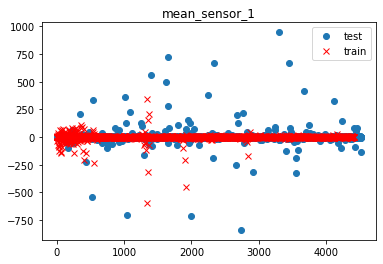

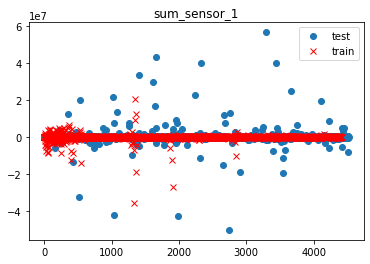

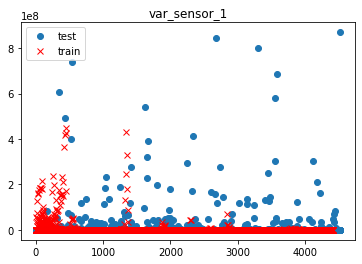

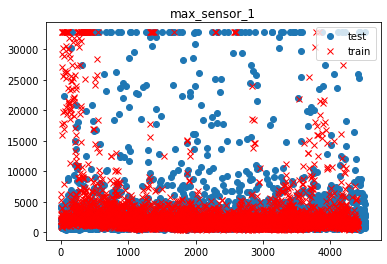

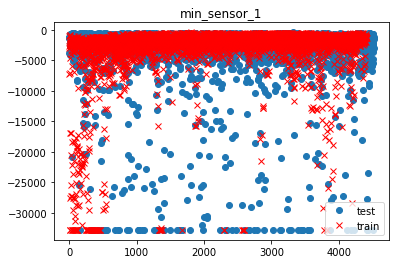

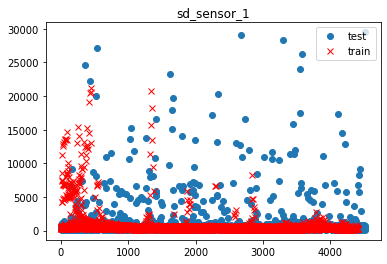

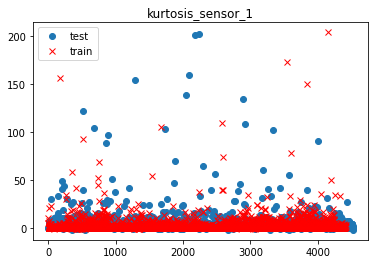

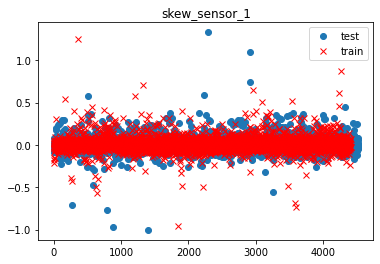

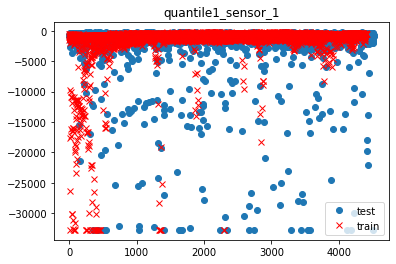

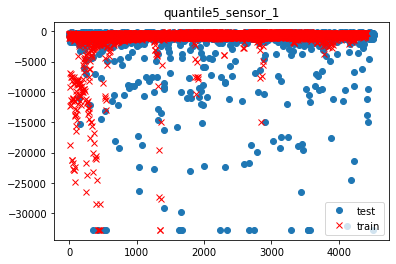

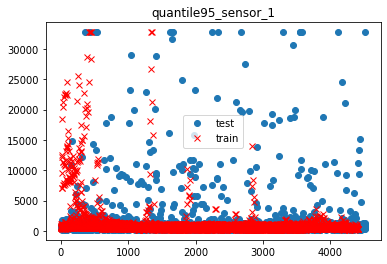

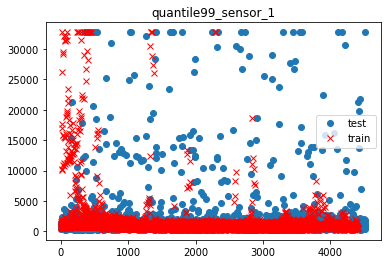

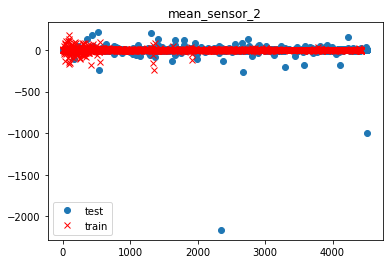

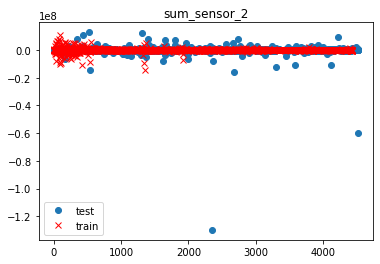

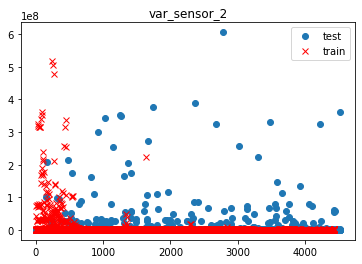

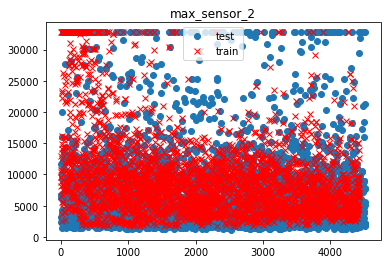

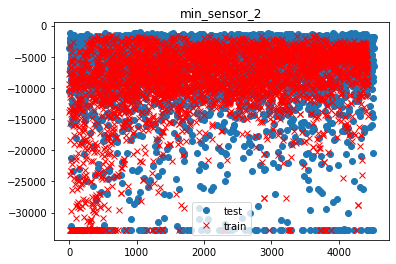

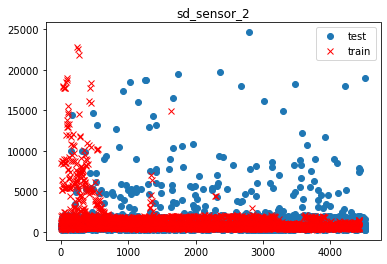

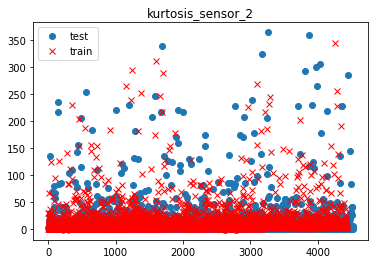

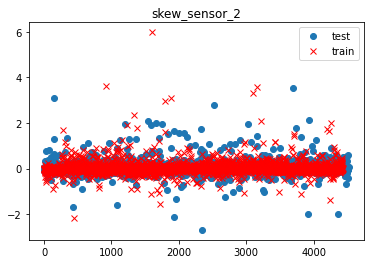

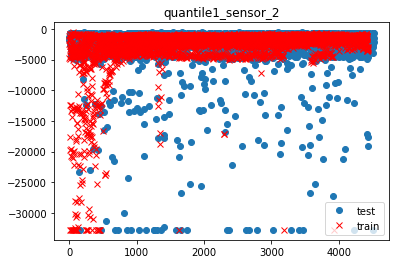

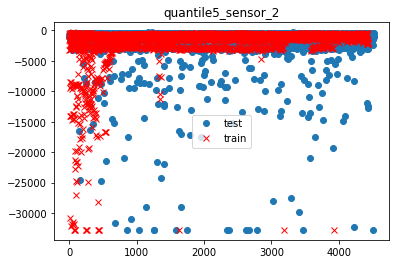

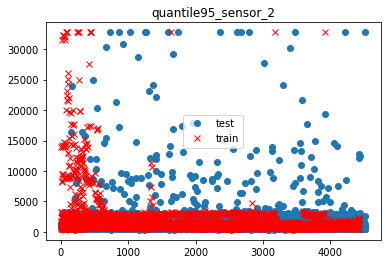

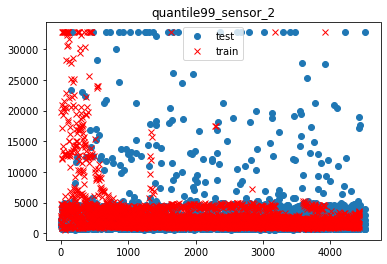

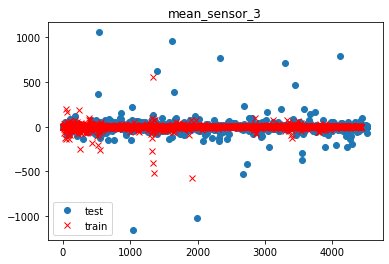

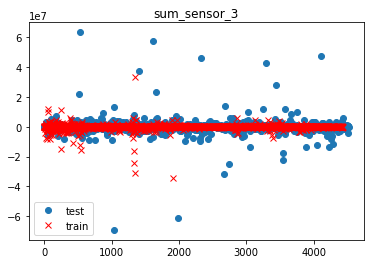

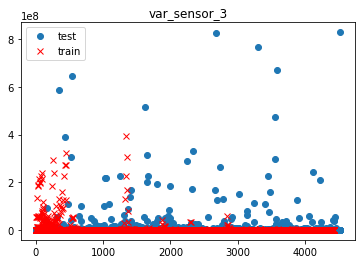

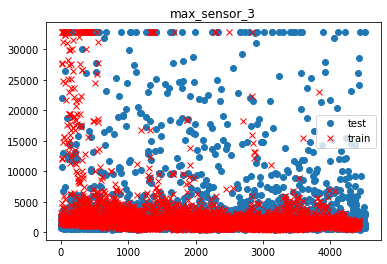

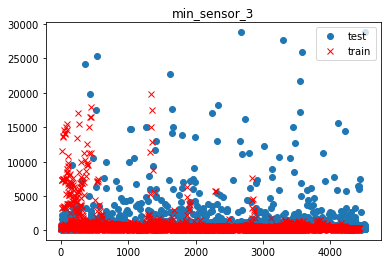

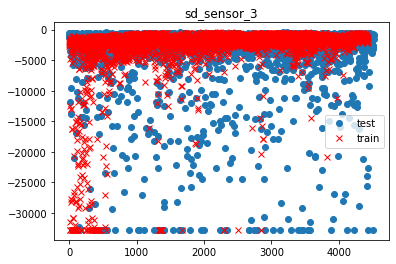

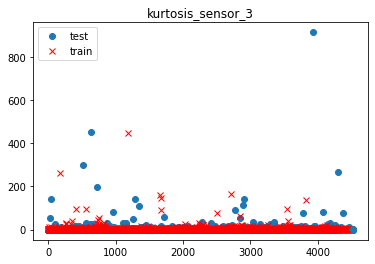

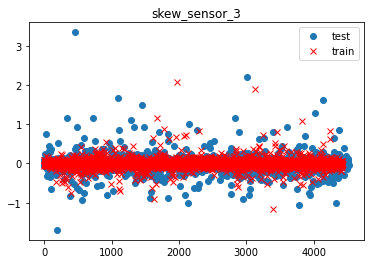

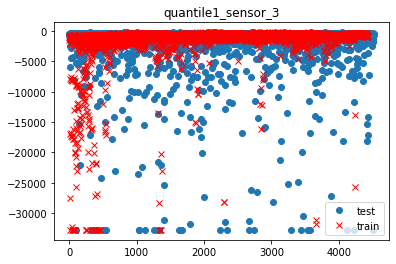

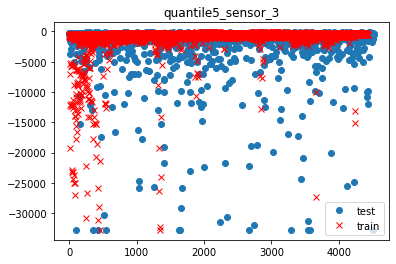

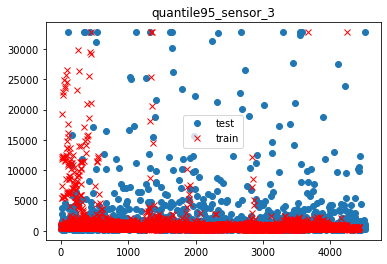

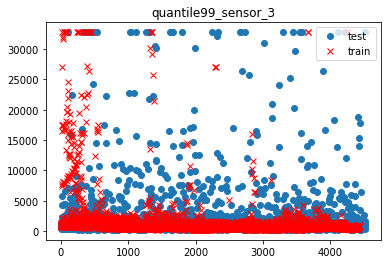

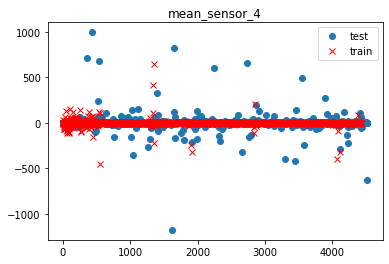

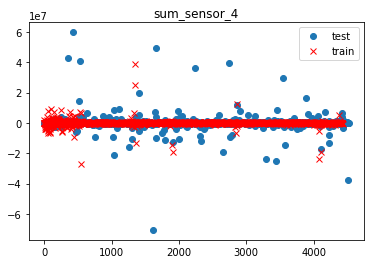

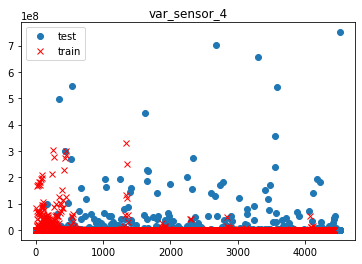

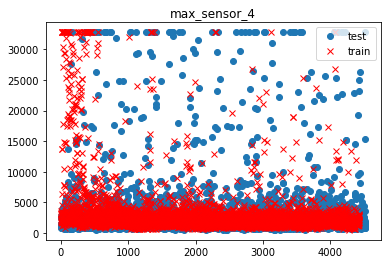

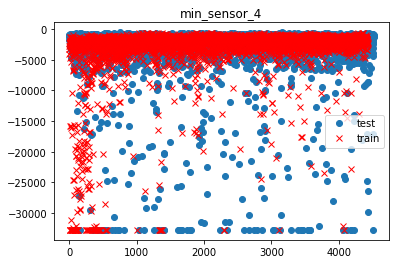

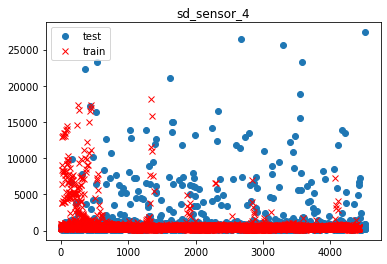

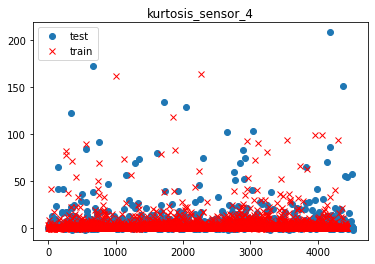

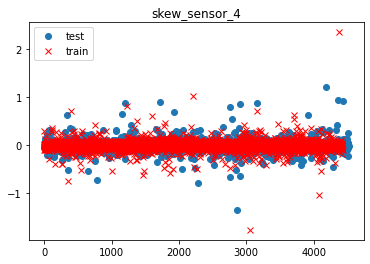

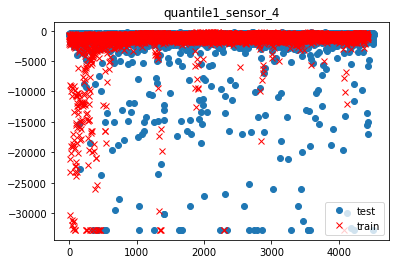

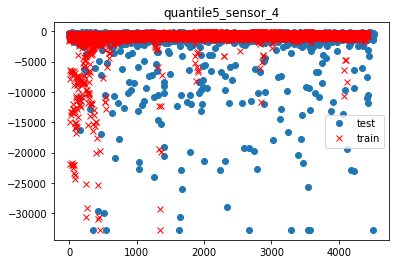

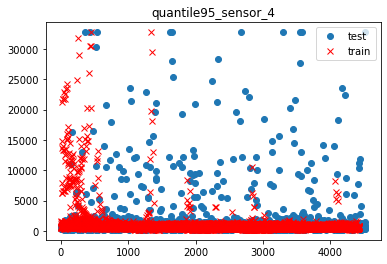

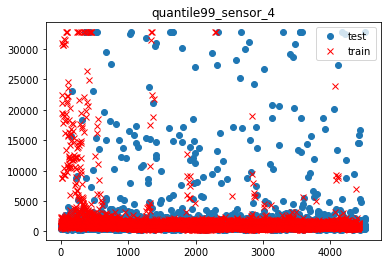

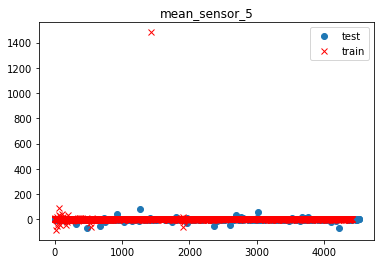

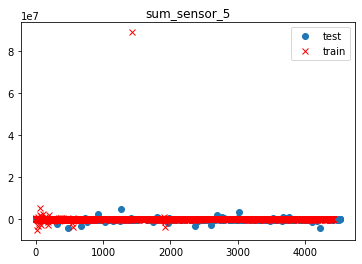

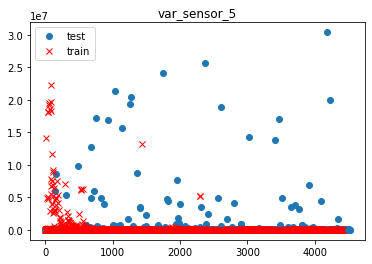

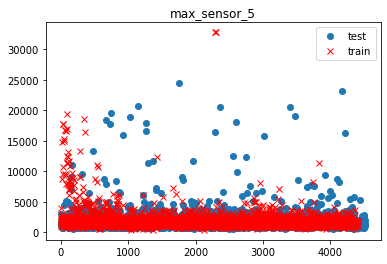

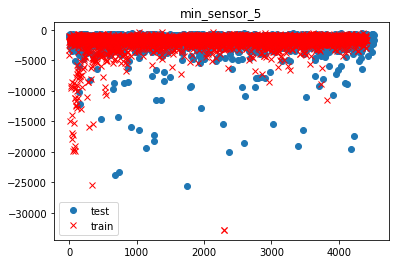

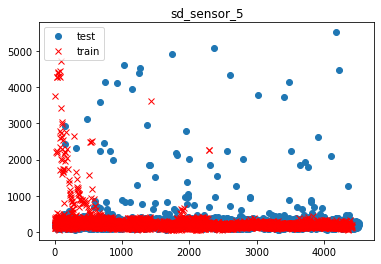

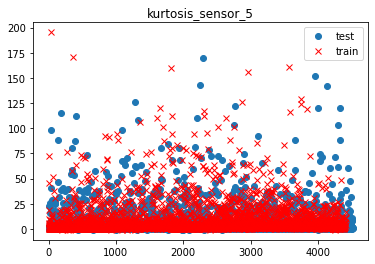

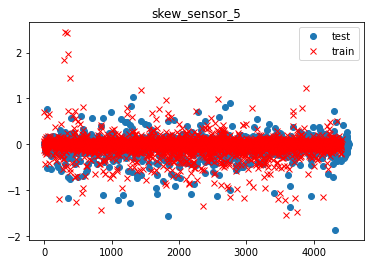

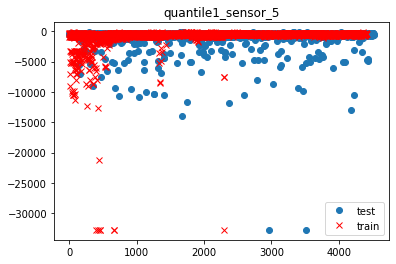

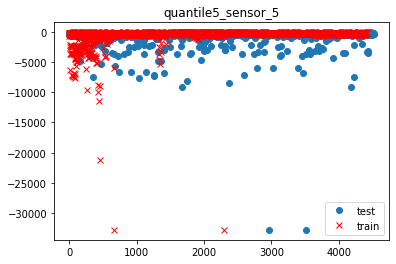

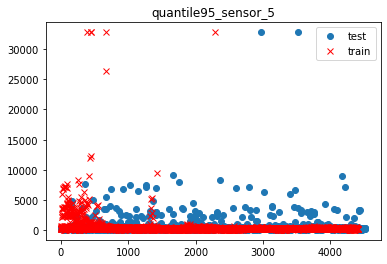

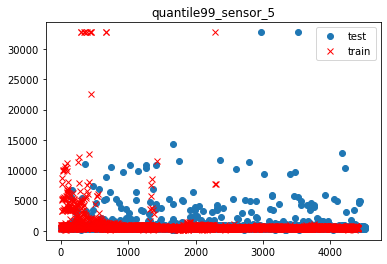

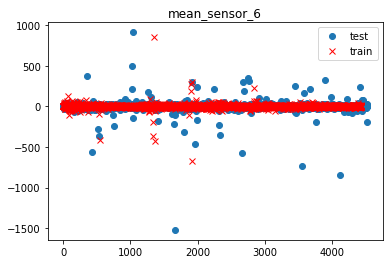

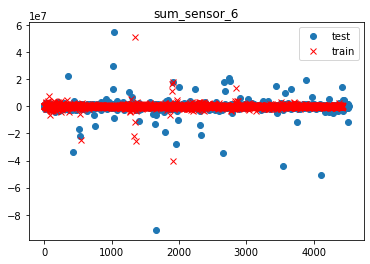

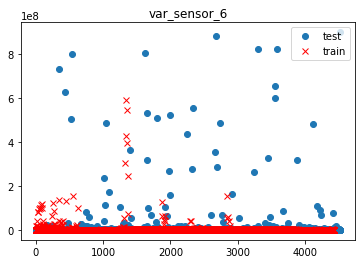

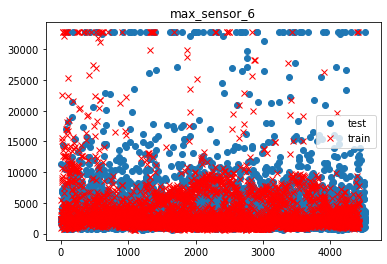

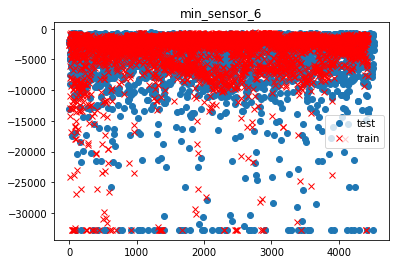

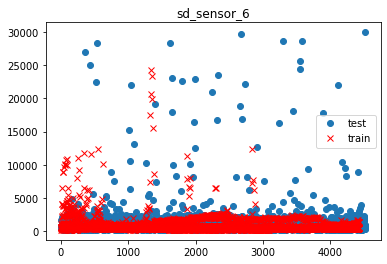

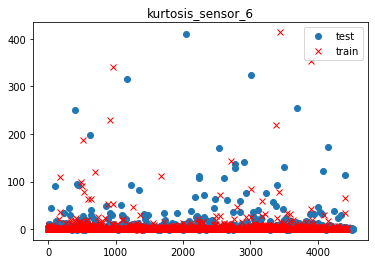

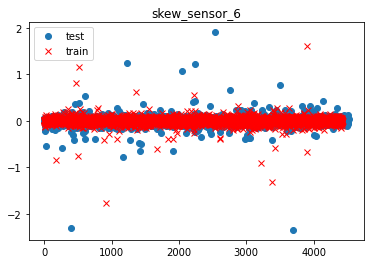

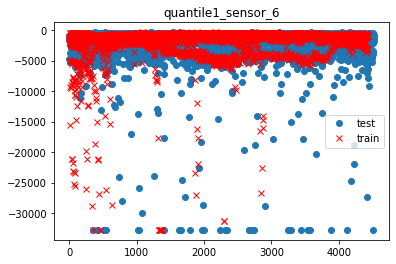

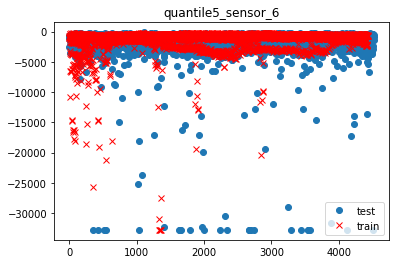

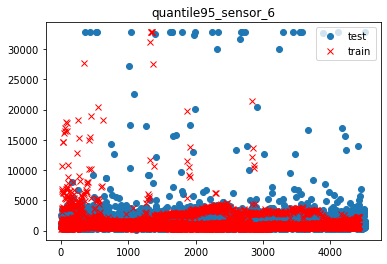

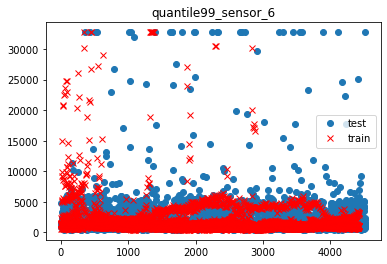

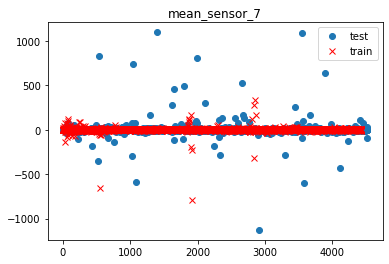

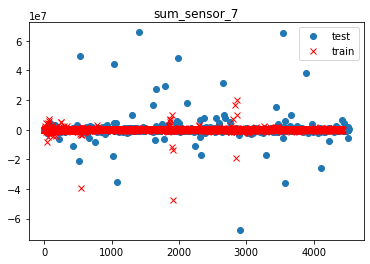

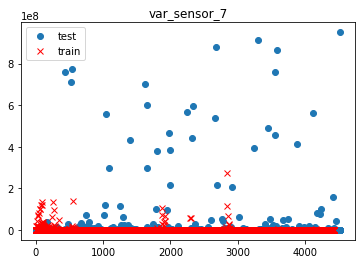

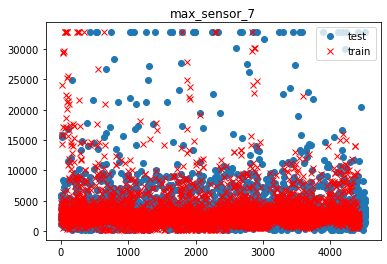

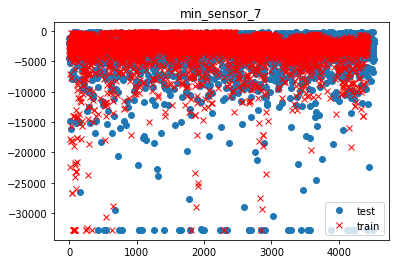

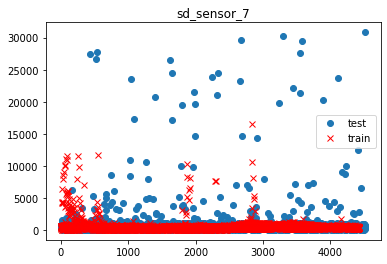

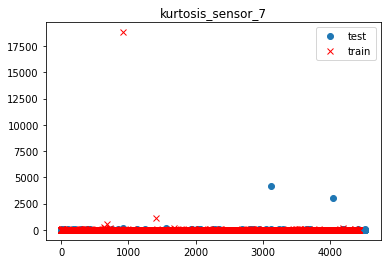

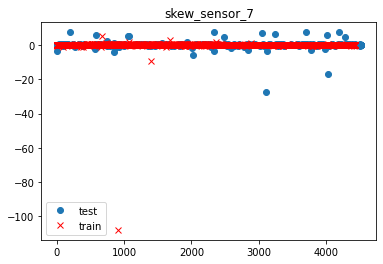

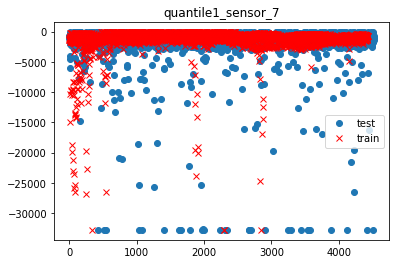

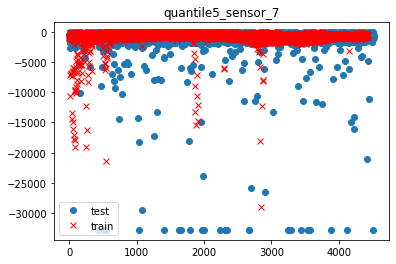

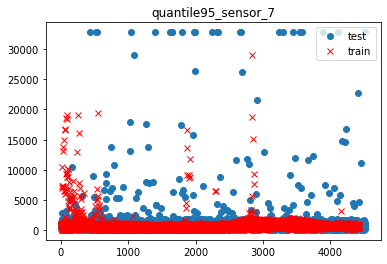

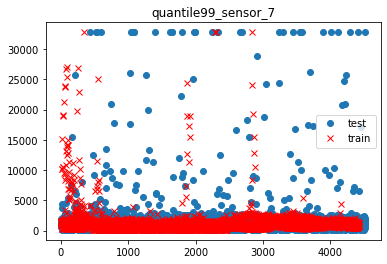

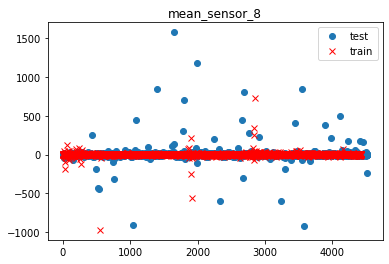

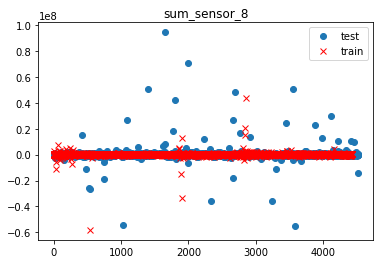

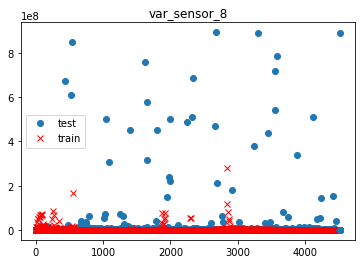

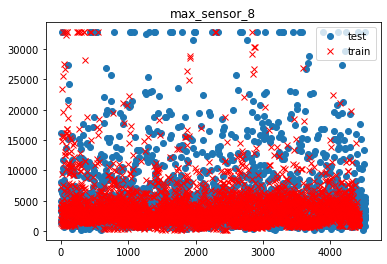

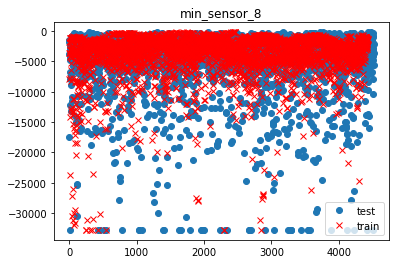

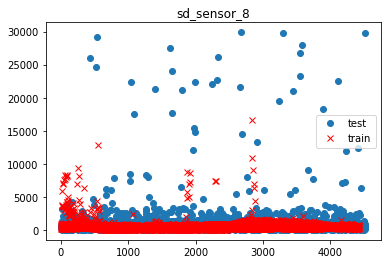

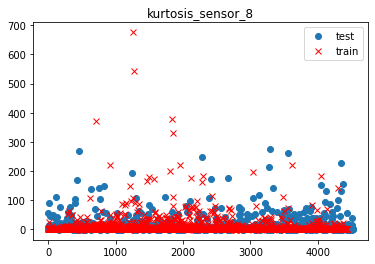

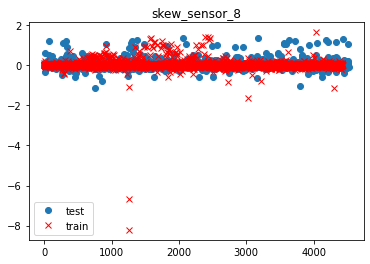

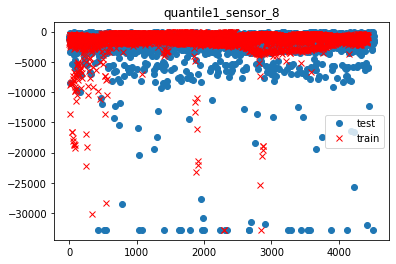

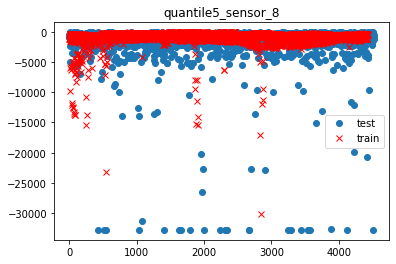

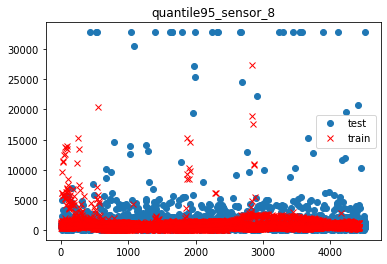

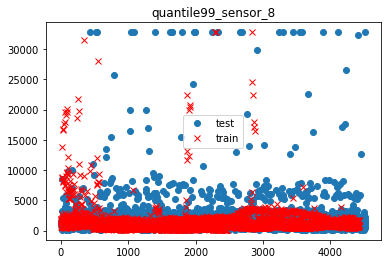

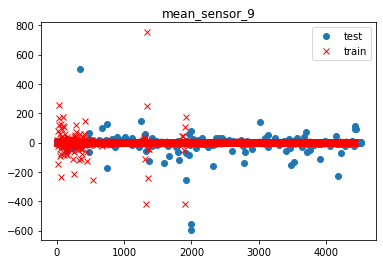

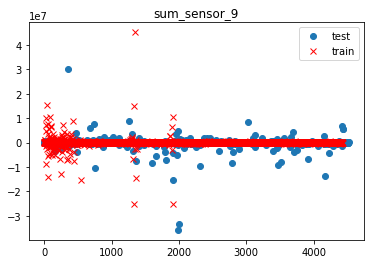

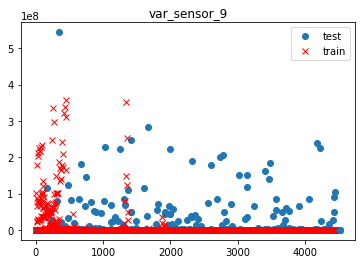

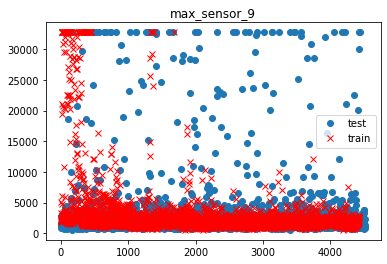

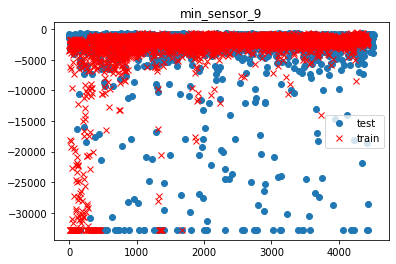

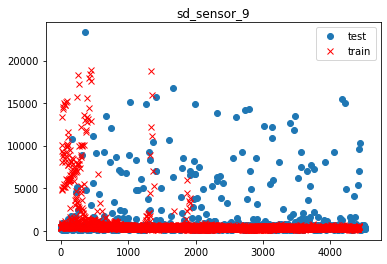

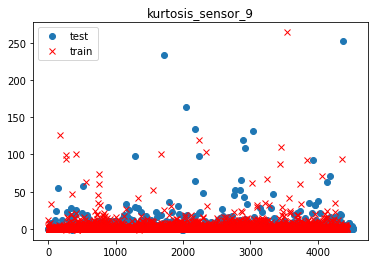

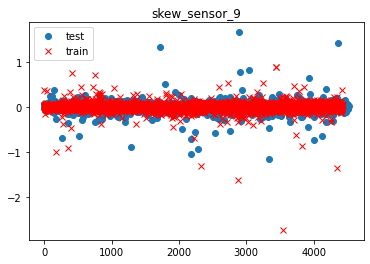

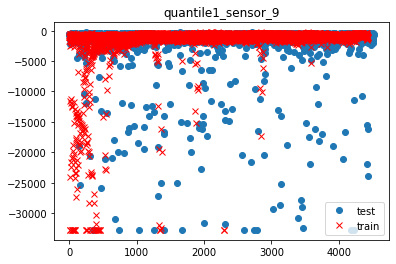

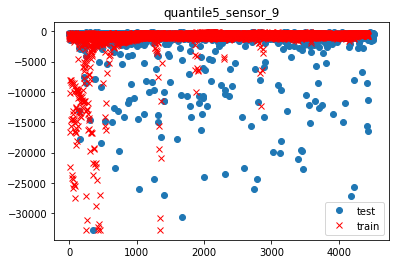

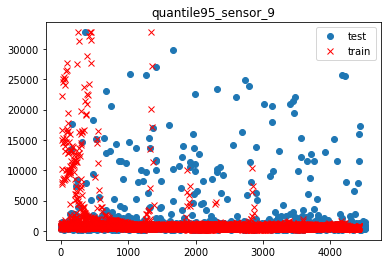

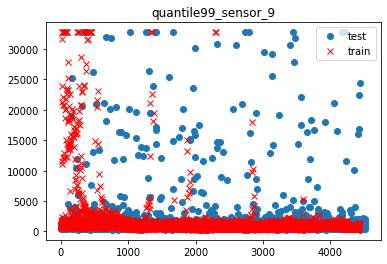

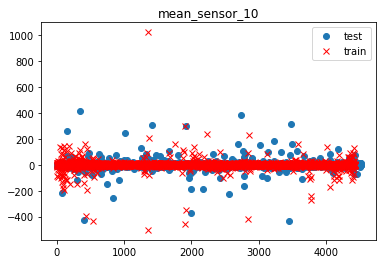

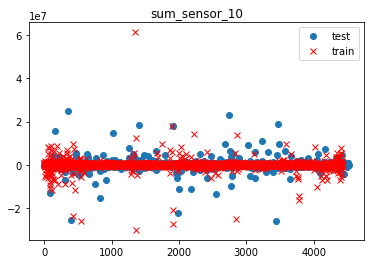

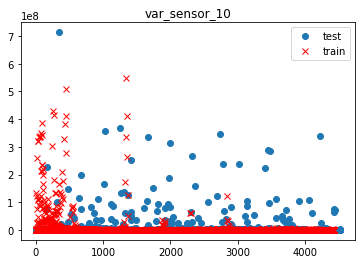

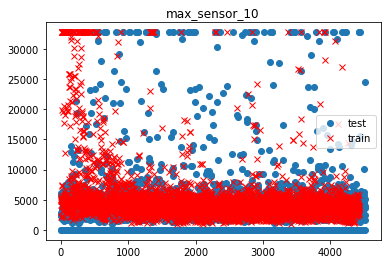

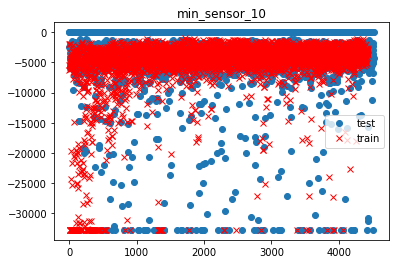

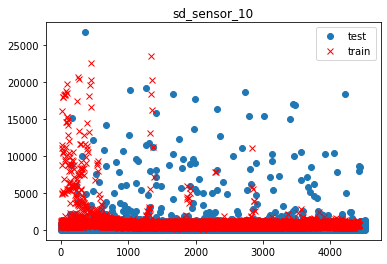

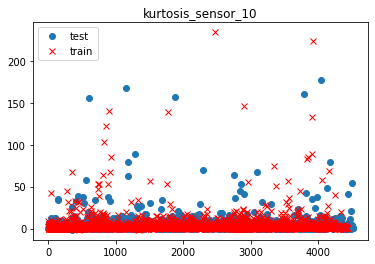

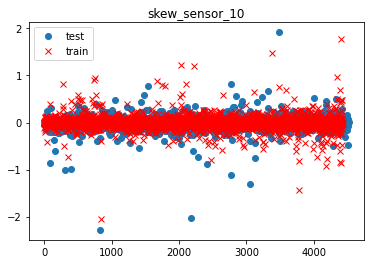

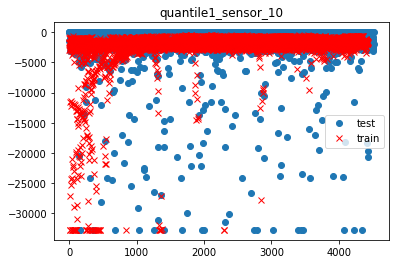

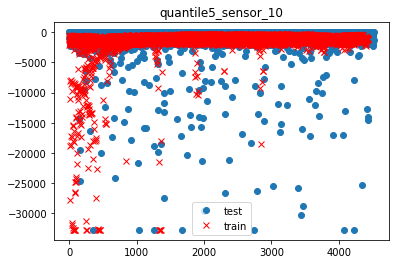

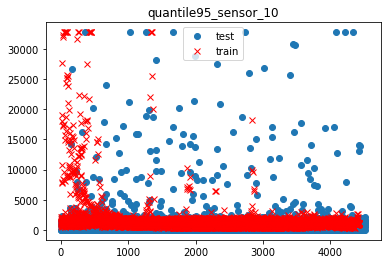

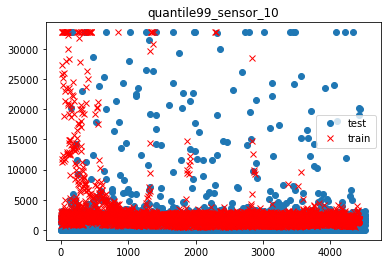

In [102]:


from matplotlib.backends.backend_pdf import PdfPages

skip = 0
sensor = 1
cnt =0
pathToSensorFolder = "./drive/MyDrive/Kaggle/predict-volcanic-eruptions-ingv-oe/Senosor Features Scatter/Train_vs_Test/"
for (columnName, columnData) in testParams.iteritems():
  if(skip>=2):
    if(cnt>11):
      sensor = sensor +1
      cnt = 0
    print('Colunm Name : ', columnName)
    #print('Column Contents : ', columnData.values)
    df=pd.concat([testParams[columnName], trainParams[columnName]], axis=1, keys=['test', 'train'])
    df.plot(style=['o','rx']).get_figure()
  #  trainParams.plot.scatter(x=columnName,y='segment_id', c='DarkBlue').get_figure()
    plt.title(columnName)
    plt.savefig(pathToSensorFolder+"train_vs_test-"+columnName+".pdf")
    cnt = cnt +1
  skip = skip+1

In [ ]:


'''
from matplotlib.backends.backend_pdf import PdfPages

skip = 0
sensor = 1
cnt =0
pathToSensorFolder = "./drive/MyDrive/Kaggle/predict-volcanic-eruptions-ingv-oe/Senosor Features Scatter/Train_vs_Test/"
for (columnName, columnData) in testParams.iteritems():
  if(skip>=2):
    if(cnt>11):
      sensor = sensor +1
      cnt = 0
    print('Colunm Name : ', columnName)
    #print('Column Contents : ', columnData.values)
    trainParams.plot.scatter(x=columnName,y='segment_id', c='DarkBlue').get_figure()
    plt.savefig(pathToSensorFolder+str(sensor)+"/test_features/"+columnName+".pdf")
    cnt = cnt +1
  skip = skip+1
  '''

In [ ]:
#from sklearn.linear_model import Ridge
#model = make_pipeline(GaussianFeatures(30), Ridge(alpha=0.1))
#basis_plot(model, title='Ridge Regression')##
#from sklearn.linear_model import Lasso
#model = make_pipeline(GaussianFeatures(30), Lasso(alpha=0.001))
#basis_plot(model, title='Lasso Regression')